## Importing the Libraries

In [1]:
!pip install matplotlib

## Import all the Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import load_model

## Loading the Params

In [3]:
"""
These two are the most important parts of training any model.
"""
path = "data_set/"   #### Path to the Images data set
labelFile = 'labels.csv' ### file containing all the labels of the shapes along with the Class Number..

"""
Setting the Parameters for trainig the models...
"""
batch_size_val = 50
steps_per_epoch = 190
epochs_val = 20

"""
Declare the image Dimensions.
All the images have to be of the same Dimensions otherwise it will throw you errors..
"""
image_Dimensions = (200,200,3)  

"""
Setting the ratios of the test, train and validation data sets.
"""
test_ratio = 0.2
validation = 0.2

## Importing the Images

In [4]:
"""
Searching for all folders and images and iterating over them.
"""
count = 0
images = []
class_No = []
myList = os.listdir(path)
print("Total Classes Detected",len(myList))
noofClasses = len(myList)
print("Importing Classes...")

for x in range(0,len(myList)):
    myPicList = os.listdir(path+"/"+str(count))
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(count)+"/"+y)
        images.append(curImg)
        class_No.append(count)
    print(count,end=" ")
    count +=1
print(" ")
images = np.array(images)
class_No = np.array(class_No)

Total Classes Detected 4
Importing Classes...
0 1 2 3  


## Splitting the Dataset

In [5]:
"""
Splitting the dataset according to the ratios declared above
"""
X_train, X_test, y_train, y_test = train_test_split(images, class_No, test_size=test_ratio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation)

In [6]:
"""
Checking the dimensions and size of all the three data sets.
"""
print("Data Shapes")
print("Train",end = "");print(X_train.shape,y_train.shape)
print("Validation",end = "");print(X_validation.shape,y_validation.shape)
print("Test",end = "");print(X_test.shape,y_test.shape)
assert(X_train.shape[0]==y_train.shape[0]), "The number of images in not equal to the number of lables in training set"
assert(X_validation.shape[0]==y_validation.shape[0]), "The number of images in not equal to the number of lables in validation set"
assert(X_test.shape[0]==y_test.shape[0]), "The number of images in not equal to the number of lables in test set"
assert(X_train.shape[1:]==(image_Dimensions))," The dimesions of the Training images are wrong "
assert(X_validation.shape[1:]==(image_Dimensions))," The dimesionas of the Validation images are wrong "
assert(X_test.shape[1:]==(image_Dimensions))," The dimesionas of the Test images are wrong"

Data Shapes
Train(9580, 200, 200, 3) (9580,)
Validation(2396, 200, 200, 3) (2396,)
Test(2994, 200, 200, 3) (2994,)


## Read CSV

In [7]:
"""
Reading the labels.csv file containig all the class names and numbers
"""
data = pd.read_csv(labelFile)
print(data.shape,type(data))

(4, 2) <class 'pandas.core.frame.DataFrame'>


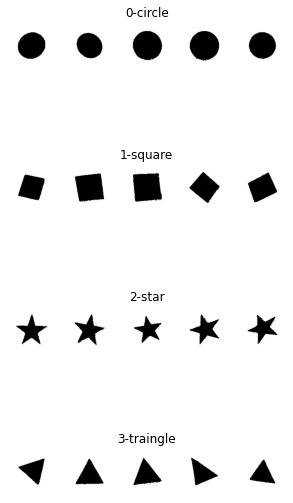

In [8]:
"""
Viewing some samples from our data set of each class.
"""
num_of_samples = []
cols = 5
num_classes = noofClasses
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,10))
# fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
#         print(axs[j][i])
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected)- 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+ "-"+row["Name"])
            num_of_samples.append(len(x_selected))

[2346, 2426, 2430, 2378]


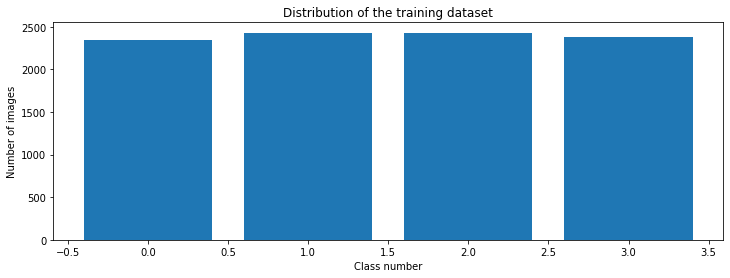

In [9]:
"""
Checking the number of the samples in each folder so that there is no uneven distribution of dataset.
"""

print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

## Image PreProcessing

In [10]:

"""
Converting the images to grayscale and standardize the ligtning of each image 
"""

def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img =cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)     # CONVERT TO GRAYSCALE
    img = equalize(img)      # STANDARDIZE THE LIGHTING IN AN IMAGE
    img = img/255            # TO NORMALIZE VALUES BETWEEN 0 AND 1 INSTEAD OF 0 TO 255
    return img

In [11]:
"""
Preprocessing the Images from each data set
"""
X_train=np.array(list(map(preprocessing,X_train)))  # TO IRETATE AND PREPROCESS ALL IMAGES
X_validation=np.array(list(map(preprocessing,X_validation)))
X_test=np.array(list(map(preprocessing,X_test)))
# cv2.imshow("GrayScale Images",X_train[random.randint(0,len(X_train)-1)]) # TO CHECK IF THE TRAINING IS DONE PROPERLY

In [12]:
     ###### ADD A DEPTH OF 1
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_validation=X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

## Data Augmentation

In [12]:
!pip install scipy

In [13]:
"""
Data Augmenatation is the process of making copies of the images in the data set and applying some kind of 
transformation on the images.
eg: Zooming the image
    Shfting the pixels to left or right on up or down
    Rotating the image
"""

'\nData Augmenatation is the process of making copies of the images in the data set and applying some kind of \ntransformation on the images.\neg: Zooming the image\n    Shfting the pixels to left or right on up or down\n    Rotating the image\n'

In [14]:
dataGen= ImageDataGenerator(width_shift_range=0.1,   # 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFFERS TO NO. OF  PIXELS EG 10 PIXELS
                            height_shift_range=0.1,
                            zoom_range=0.2,  # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
                            shear_range=0.1,  # MAGNITUDE OF SHEAR ANGLE
                            rotation_range=10)
dataGen.fit(X_train)
batches= dataGen.flow(X_train,y_train,batch_size=50,save_to_dir='Augmented_out/')  # REQUESTING DATA GENRATOR TO GENERATE IMAGES  BATCH SIZE = NO. OF IMAGES CREAED EACH TIME ITS CALLED
X_batch,y_batch = next(batches)

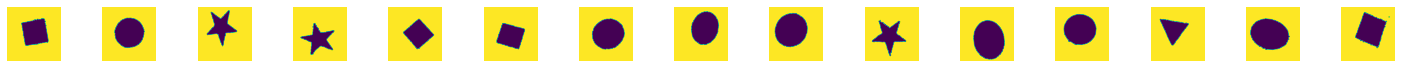

In [16]:
"""
Viewing the Augmented the data
"""
fig,axs=plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(image_Dimensions[0],image_Dimensions[1]))
    axs[i].axis('off')
plt.show()
 
 
y_train = to_categorical(y_train,noofClasses)
y_validation = to_categorical(y_validation,noofClasses)
y_test = to_categorical(y_test,noofClasses)

## Making the Neural Network by declaring the number of neurons,weights and layers 

In [17]:
def myModel():
    no_Of_Filters=60
    size_of_Filter=(5,5) # THIS IS THE KERNEL THAT MOVE AROUND THE IMAGE TO GET THE FEATURES.
                         # THIS WOULD REMOVE 2 PIXELS FROM EACH BORDER WHEN USING 32 32 IMAGE
    size_of_Filter2=(3,3)
    size_of_pool=(2,2)  # SCALE DOWN ALL FEATURE MAP TO GERNALIZE MORE, TO REDUCE OVERFITTING
    no_Of_Nodes = 500   # NO. OF NODES IN HIDDEN LAYERS
    model= Sequential()
    model.add((Conv2D(no_Of_Filters,size_of_Filter,input_shape=(image_Dimensions[0],image_Dimensions[1],1),activation='relu')))  # ADDING MORE CONVOLUTION LAYERS = LESS FEATURES BUT CAN CAUSE ACCURACY TO INCREASE
    model.add((Conv2D(no_Of_Filters, size_of_Filter, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool)) # DOES NOT EFFECT THE DEPTH/NO OF FILTERS
 
    model.add((Conv2D(no_Of_Filters//2, size_of_Filter2,activation='relu')))
    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))
 
    model.add(Flatten())
    model.add(Dense(no_Of_Nodes,activation='relu'))
    model.add(Dropout(0.5)) # INPUTS NODES TO DROP WITH EACH UPDATE 1 ALL 0 NONE
    model.add(Dense(noofClasses,activation='softmax')) # OUTPUT LAYER
    # COMPILE MODEL
    model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model
 

In [19]:
"""
Training the dataset for the above mentioned parameters/ Neural Network
"""

'\nTraining the dataset for the above mentioned parameters/ Neural Network\n'

In [20]:
model = myModel()
print(model.summary())
history=model.fit_generator(dataGen.flow(X_train,y_train,batch_size=batch_size_val),steps_per_epoch=steps_per_epoch,epochs=epochs_val,validation_data=(X_validation,y_validation),shuffle=1)

C:\Users\PUsH\Desktop 1\Shape_rec\shape\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 196, 196, 60)      1560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 192, 60)      90060     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 94, 94, 30)        16230     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 92, 92, 30)        8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 30)        0         
_________________________________________________________________
dropout (Dropout)            (None, 46, 46, 30)        0

C:\Users\PUsH\Desktop 1\Shape_rec\shape\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20


InvalidArgumentError:  Can not squeeze dim[2], expected a dimension of 1, got 4
	 [[node categorical_crossentropy/remove_squeezable_dimensions/Squeeze (defined at Users\PUsH\AppData\Local\Temp/ipykernel_3288/697434126.py:3) ]] [Op:__inference_train_function_987]

Function call stack:
train_function


In [22]:

"""
After the training process is over we will get a fully trained model and we will save it to apply it in our
various applications
"""

'\nAfter the training process is over we will get a fully trained model and we will save it to apply it in our\nvarious applications\n'

In [ ]:
model.save('my_model.h5')

In [ ]:
                                    """ Training Process Done  """